In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/cheyuriy/miniconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Данных мало и можно загрузить их все в память.

In [3]:
train_data = pd.read_csv("./data/products_sentiment_train.tsv", sep="\t", header=None, names=["text", "target"])
test_data = pd.read_csv("./data/products_sentiment_test.tsv", sep="\t")

### Анализ данных

Посмотрим на несколько примеров текстов.

In [4]:
print(train_data["text"][0])
print(train_data["text"][7])
print(train_data["text"][100])
print(train_data["text"][1000])
print(train_data["text"][228])

2 . take around 10,000 640x480 pictures .
from the internet , woodworking books , local stores and personal opinions the hitachi m12v 3-1 / 4 hp router time and time again came up to be the router of choice or best for its price .
after multilple tries , one of the disks was finally recognized but video was poor and features not available . 
if you 've been listening to cd 's in your car for awhile , dealing with the drop-off in sound quality may take some getting used to .
the door would not close . 


Можно заметить, что тексты предобработаны и токены достаточно корректно разделимы пробелами. Это упростит нашу задачу по токенизации в дальнейшем. Также можно заметить, что в тексте присутствуют числа и номера, а также сложные обозначения.

Попробуем провести токенизацию простейшим способом (разбивая по пробелам). После этого посмотрим на наиболее и наименее употребимые слова в получаемом мешке слов.

In [5]:
X = train_data["text"]
Y = train_data["target"]

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorized_X = vectorizer.fit_transform(X)
print("Total number of tokens (naive split):", vectorized_X.shape[1])
tokens = pd.DataFrame(vectorized_X.sum(axis=0).T, index=vectorizer.get_feature_names(), columns=["count"])

/home/cheyuriy/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/cheyuriy/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/cheyuriy/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/cheyuriy/miniconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Total number of tokens (naive split): 3973


In [7]:
print("The least frequent tokens:")
tokens.sort_values(by="count").head(10)

The least frequent tokens:


,count
lines,1
funny,1
funky,1
reducer,1
functioning,1
reduction,1
reeves,1
refer,1
refill,1
fumble,1


In [8]:
print("The most frequent tokens:")
tokens.sort_values(by="count").tail(10)

The most frequent tokens:


,count
you,383
for,386
this,409
with,412
of,471
is,836
it,855
to,915
and,1009
the,2073


Как видно, среди наиболее частых слов все можно отнести к общеупотребительным стоп-словам. В дальнейшем мы попытаемся избавиться от них как от малозначащих. Для этого подсчитаем частоту появления таких слов среди всей массы слов и, определив некий порог, отсечём те, которые будем считать стоп-словами.

In [9]:
tokens["tf"] = tokens["count"]/tokens["count"].sum()
tokens.sort_values(by="count").tail(20)

,count,tf
very,168,0.005173
are,197,0.006066
as,223,0.006867
my,239,0.007359
on,251,0.007729
not,259,0.007975
but,264,0.008129
have,271,0.008345
in,315,0.009699
that,364,0.011208


In [10]:
stop_words = list(tokens.loc[tokens.tf > 0.006].index)
stop_words

['and',
 'are',
 'as',
 'but',
 'for',
 'have',
 'in',
 'is',
 'it',
 'my',
 'not',
 'of',
 'on',
 'that',
 'the',
 'this',
 'to',
 'with',
 'you']

В качестве отсечки мы взяли частоту появления слова выше 0.006. Видно, что в эту группу попали слова, которые трудно отнести к определяющим тональность отзыва, а значит можно расчитывать, что их удаление не повредит модели.
Однако стоит иметь ввиду, что эти слова могут быть достаточно важными при построении n-грам (например, слово not может кардинально поменять тональность рядом стоящего слова). Кроме того, мы могли бы использовать векторизацию через Tf-Idf, которая штрафует слишком частые слова, тем самым использование списка стоп-слов может быть и вовсе ненужным. Поэтому в дальнейшем мы будем использовать стоп-слова только при проверке моделей на основе частот, а не Tf-Idf.

Теперь давайте попробуем визуализировать частоту появления слов в текстах разных тональностей. Вероятно, мы сможем определить некоторую закономерность.

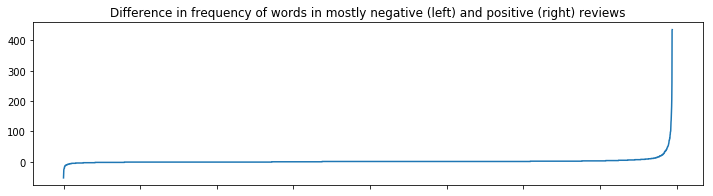

In [19]:
vectorizer = CountVectorizer()
vectorized_positive = vectorizer.fit_transform(list(train_data.loc[train_data.target == 1]["text"]))
vectorized_positive = pd.DataFrame(vectorized_positive.sum(axis=0).T, index=vectorizer.get_feature_names(), columns=["positive"])

vectorizer = CountVectorizer()
vectorized_negative = vectorizer.fit_transform(train_data.loc[train_data.target == 0]["text"])
vectorized_negative = pd.DataFrame(vectorized_negative.sum(axis=0).T, index=vectorizer.get_feature_names(), columns=["negative"])

tokens = pd.merge(vectorized_negative, vectorized_positive, how="outer", left_index=True, right_index=True)
tokens = tokens.fillna(0)
tokens["diff"] = tokens["positive"] - tokens["negative"]

plt.figure(figsize=(12, 3))
tokens["diff"].sort_values().plot(title = "Difference in frequency of words in mostly negative (left) and positive (right) reviews")
plt.show()

Как видно из графика большинство слов одинаково часто встречаются как в положительных, так и в отрицательных отзывах. Лишь малая часть слов встречается значимо чаще в одной категории отзывов. Однако мы можем надеяться что классификитор, основанный на частоте слов, сможет успешно обучиться на них. Давайте посмотрим на эти слова.

In [20]:
print("The most important tokens in positive reviews:")
tokens.sort_values(by="diff").tail(20)

The most important tokens in positive reviews:


,negative,positive,diff
you,156.0,227.0,71.0
all,42.0,114.0,72.0
quality,23.0,100.0,77.0
in,118.0,197.0,79.0
phone,41.0,120.0,79.0
easy,10.0,99.0,89.0
very,39.0,129.0,90.0
use,27.0,125.0,98.0
good,14.0,113.0,99.0
camera,33.0,135.0,102.0


In [21]:
print("The most important tokens in negative reviews:")
tokens.sort_values(by="diff").head(20)

The most important tokens in negative reviews:


,negative,positive,diff
not,156.0,103.0,-53.0
only,67.0,28.0,-39.0
would,58.0,32.0,-26.0
after,40.0,16.0,-24.0
problem,38.0,16.0,-22.0
they,53.0,32.0,-21.0
norton,25.0,4.0,-21.0
does,50.0,34.0,-16.0
their,30.0,15.0,-15.0
when,49.0,35.0,-14.0


Видно, что многие слова были нами ранее отнесены к стоп-словам. Возможно по какой-то причине эти слова действительно могут определять тональность текста. Поэтому мы попробуем в дальнейшем как включать их в модель, так и исключать.

### Baseline-модели

Перейдём непосредственно к проверке нескольких моделей. В качестве классификаторов попробуем использовать часто применяемые к таким задачам Multinomial Naive-Bayes classificator, Linear SVC, Ridge classificator.
В качестве векторизаторов попробуем:
* векторизатор по частоте слов
    * с 1-1, 1-2 и 1-3 n-грамами
    * со стоп словами и без
    * с наивным токенизатором и токенизатором для анализа твитов из библиотеки nltk и стеммингом
* векторизатор по Tf-Idf
    * с 1-1, 1-2 и 1-3 n-грамами
    * с наивным токенизатором и токенизатором для анализа твитов из библиотеки nltk и стеммингом
    
Для оценки наших кандидатов мы будем проводить кросс-валидацию на 10 свёртках. Метрикой будет выступать точность.

In [59]:
#Note, that you need to download parts of nltk to make this part work.
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

class TwitterTokenizerStemmer(object):
    def __init__(self):
        self.snowball_stemmer = SnowballStemmer("english")
        self.tokenizer = TweetTokenizer(preserve_case=False)
    def __call__(self, doc):
        tokenized_doc = self.tokenizer.tokenize(doc)
        return " ".join([self.snowball_stemmer.stem(x) for x in tokenized_doc])

In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from itertools import product

In [33]:
#helper function to evaluate bunch of pipelines passed as argument
def run_pipelines(pipelines, x, y, cv=10):
    results = dict()
    for (i, pipeline) in enumerate(pipelines):
        pipeline_name = ":".join([str(i), pipeline.steps[0][0], pipeline.steps[1][0]])
        print("Evaluating", pipeline_name)
        results[pipeline_name] = np.mean(cross_val_score(pipeline, x, y, scoring="accuracy", cv=cv, n_jobs=-1))
    return results

In [38]:
vectorizers = [CountVectorizer(ngram_range=(1,1)), 
               CountVectorizer(ngram_range=(1,2)),
               CountVectorizer(ngram_range=(1,3)),
               CountVectorizer(ngram_range=(1,1), stop_words=stop_words), 
               CountVectorizer(ngram_range=(1,2), stop_words=stop_words),
               CountVectorizer(ngram_range=(1,3), stop_words=stop_words),
               CountVectorizer(ngram_range=(1,1), preprocessor=TwitterTokenizerStemmer()), 
               CountVectorizer(ngram_range=(1,2), preprocessor=TwitterTokenizerStemmer()),
               CountVectorizer(ngram_range=(1,3), preprocessor=TwitterTokenizerStemmer()),
               CountVectorizer(ngram_range=(1,1), stop_words=stop_words, preprocessor=TwitterTokenizerStemmer()), 
               CountVectorizer(ngram_range=(1,2), stop_words=stop_words, preprocessor=TwitterTokenizerStemmer()),
               CountVectorizer(ngram_range=(1,3), stop_words=stop_words, preprocessor=TwitterTokenizerStemmer()),
               TfidfVectorizer(ngram_range=(1,1)),
               TfidfVectorizer(ngram_range=(1,2)),
               TfidfVectorizer(ngram_range=(1,3)),
               TfidfVectorizer(ngram_range=(1,1), preprocessor=TwitterTokenizerStemmer()),
               TfidfVectorizer(ngram_range=(1,2), preprocessor=TwitterTokenizerStemmer()),
               TfidfVectorizer(ngram_range=(1,3), preprocessor=TwitterTokenizerStemmer()),
               TfidfVectorizer(ngram_range=(1,1), stop_words=stop_words),
               TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words),
               TfidfVectorizer(ngram_range=(1,3), stop_words=stop_words),
               TfidfVectorizer(ngram_range=(1,1), stop_words=stop_words, preprocessor=TwitterTokenizerStemmer()),
               TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words, preprocessor=TwitterTokenizerStemmer()),
               TfidfVectorizer(ngram_range=(1,3), stop_words=stop_words, preprocessor=TwitterTokenizerStemmer())
              ]
models = [LinearSVC(), 
          MultinomialNB(), 
          RidgeClassifier()
         ]
pipelines_to_evaluate = list(
    map(lambda x: make_pipeline(*x), 
        product(vectorizers, models))
)

In [39]:
#it will take time
np.random.seed(1)
%time
results = run_pipelines(pipelines_to_evaluate, X, Y)
%time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.29 µs
Evaluating 0:countvectorizer:linearsvc
Evaluating 1:countvectorizer:multinomialnb
Evaluating 2:countvectorizer:ridgeclassifier
Evaluating 3:countvectorizer:linearsvc
Evaluating 4:countvectorizer:multinomialnb
Evaluating 5:countvectorizer:ridgeclassifier
Evaluating 6:countvectorizer:linearsvc
Evaluating 7:countvectorizer:multinomialnb
Evaluating 8:countvectorizer:ridgeclassifier
Evaluating 9:countvectorizer:linearsvc
Evaluating 10:countvectorizer:multinomialnb
Evaluating 11:countvectorizer:ridgeclassifier
Evaluating 12:countvectorizer:linearsvc
Evaluating 13:countvectorizer:multinomialnb
Evaluating 14:countvectorizer:ridgeclassifier
Evaluating 15:countvectorizer:linearsvc
Evaluating 16:countvectorizer:multinomialnb
Evaluating 17:countvectorizer:ridgeclassifier
Evaluating 18:countvectorizer:linearsvc
Evaluating 19:countvectorizer:multinomialnb
Evaluating 20:countvectorizer:ridgeclassifier
Evaluating 21:countvectorizer:linear

Посмотрим подробнее на наиболее успешные комбинации

In [70]:
for r in sorted(results.items(), key=lambda x: -x[1])[0:5]:
    i = int(r[0].split(":")[0])
    pipeline = pipelines_to_evaluate[i]
    vectorizer = pipeline.steps[0][0]
    ngram_range = pipeline.steps[0][1].ngram_range
    preprocessor = pipeline.steps[0][1].preprocessor
    stopwords = bool(pipeline.steps[0][1].stop_words)
    model = pipeline.steps[1][0]
    print("Model:", model,
          "with",vectorizer,
          "(ngram_range:",ngram_range,
          "preprocessor:",preprocessor,
          "stopwords:",stopwords,")", "accuracy:",r[1])

Model: multinomialnb with countvectorizer (ngram_range: (1, 1) preprocessor: <__main__.TwitterTokenizerStemmer object at 0x7fcbd4594438> stopwords: True ) accuracy: 0.7944682617065427
Model: multinomialnb with countvectorizer (ngram_range: (1, 1) preprocessor: <__main__.TwitterTokenizerStemmer object at 0x7fcbd4612780> stopwords: False ) accuracy: 0.7939883372084303
Model: linearsvc with tfidfvectorizer (ngram_range: (1, 3) preprocessor: <__main__.TwitterTokenizerStemmer object at 0x7fcbd4594b70> stopwords: False ) accuracy: 0.793480799519988
Model: ridgeclassifier with tfidfvectorizer (ngram_range: (1, 2) preprocessor: <__main__.TwitterTokenizerStemmer object at 0x7fcbd4594a20> stopwords: False ) accuracy: 0.7914732868321709
Model: ridgeclassifier with tfidfvectorizer (ngram_range: (1, 2) preprocessor: <__main__.TwitterTokenizerStemmer object at 0x7fcbd4594f60> stopwords: True ) accuracy: 0.790948236205905


Интересное наблюдение, что Multinomial Naive-Bayes показал наилучший результат только на униграмах, причём наличие стоп-слов добавило точности. Обратная ситуация наблюдается для других моделей: они показали себя лучше в условиях наличия как биграмм, так и триграмм, а также не так очевидна польза стоп-слов.
В качестве дальнейших моделей для улучшения возьмём:
* Multinomial Naive-Bayes c частотным векторизатором на униграммах с фильтрацией стоп-слов
* Linear SVC с Tf-Idf векторизатором на 1-3-граммах без фильтрации стоп-слов

В обоих случаях будем использовать наш сложный токенизатор со стеммингом.

### Multinomial Naive-Bayes

Остановим внимание на том факте, что добавление стоп-слов улучшило результат данного классификатора. Попробуем расширить список таких слов, но при этом вручную сохраним те слова, которые на наш взгляд могут быть важны для определения тональности.

In [106]:
vectorizer = CountVectorizer()
vectorized_X = vectorizer.fit_transform(X)
tokens = pd.DataFrame(vectorized_X.sum(axis=0).T, index=vectorizer.get_feature_names(), columns=["count"])
tokens["tf"] = tokens["count"]/tokens["count"].sum()

vectorizers = list()
list_stop_words = list()
df_thresholds_to_test = np.linspace(0.0015, 0.006, 10)
for threshold in df_thresholds_to_test:
    list_stop_words += [set(tokens.loc[tokens.tf > threshold].index) - set(["but", "easy", "features", "good", "great", "like", "more", "not", "no", "only", "quality", "than", "very", "well", "work", "zen", "best", "better", "creative", "excellent", "just", "little", "love", "much", "price", "problem", "problems", "small", "some"])]
    vectorizers += [CountVectorizer(ngram_range=(1,1), stop_words=list_stop_words[-1], preprocessor=TwitterTokenizerStemmer())]
    
models = [MultinomialNB()]

pipelines_to_evaluate = list(
    map(lambda x: make_pipeline(*x), 
        product(vectorizers, models))
)

In [107]:
%time
results = run_pipelines(pipelines_to_evaluate, X, Y)
%time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs
Evaluating 0:countvectorizer:multinomialnb
Evaluating 1:countvectorizer:multinomialnb
Evaluating 2:countvectorizer:multinomialnb
Evaluating 3:countvectorizer:multinomialnb
Evaluating 4:countvectorizer:multinomialnb
Evaluating 5:countvectorizer:multinomialnb
Evaluating 6:countvectorizer:multinomialnb
Evaluating 7:countvectorizer:multinomialnb
Evaluating 8:countvectorizer:multinomialnb
Evaluating 9:countvectorizer:multinomialnb
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


In [113]:
best_pipeline_num = int(sorted(results.items(), key=lambda x: -x[1])[0][0].split(":")[0])
optimal_stop_words = list(pipelines_to_evaluate[best_pipeline_num].steps[0][1].stop_words)
print("Optimal df threshold:",df_thresholds_to_test[best_pipeline_num])
print("Optimal stopword list:", pipelines_to_evaluate[best_pipeline_num].steps[0][1].stop_words)
print("Accuracy:", sorted(results.items(), key=lambda x: -x[1])[0][1])

Optimal df threshold: 0.005
Optimal stopword list: {'that', 'to', 'can', 'is', 'in', 'and', 'this', 'of', 'it', 'my', 'with', 'have', 'for', 'as', 'are', 'camera', 'the', 'you', 'on'}
Accuracy: 0.7969709242731069


Далее мы попробуем подогнать прочие параметры токенизатора и модели путём поиска по сетке.

In [121]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipe = Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1,1), preprocessor=TwitterTokenizerStemmer(), stop_words=optimal_stop_words)), 
                       ('model', MultinomialNB())])
param_grid = {
    'vectorizer__min_df': np.linspace(0.0,0.1,num=11),
    'vectorizer__max_df': np.linspace(0.6,0.8,num=11),
    'model__alpha': np.linspace(1.0,10.0,num=11)
}

In [122]:
search = GridSearchCV(pipe, param_grid, iid=True, cv=10, return_train_score=False, scoring="accuracy", n_jobs=-1, verbose=True)

In [123]:
search.fit(X,Y)

Fitting 10 folds for each of 1331 candidates, totalling 13310 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 11234 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 12784 tasks      | elapsed: 28

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<__main__.TwitterToken...izer=None, vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vectorizer__max_df': array([0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 ]), 'model__alpha': array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]), 'vectorizer__min_df': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=True)

In [124]:
search.best_score_

0.7985

In [125]:
search.best_params_

{'model__alpha': 1.9, 'vectorizer__max_df': 0.6, 'vectorizer__min_df': 0.0}

Особого выигрыша от подгонки параметров не получили, однако точность на кроссвалидации очень близка к требуемому порогу. Соберём модель ещё раз, получим предсказания для тестового набора данных.

In [127]:
vectorizer = CountVectorizer(ngram_range=(1,1), preprocessor=TwitterTokenizerStemmer(), stop_words=optimal_stop_words, max_df=0.6, min_df=0.0)
vectorized_X = vectorizer.fit_transform(X)

0.7959883622090553

In [128]:
clf = MultinomialNB(alpha=1.9)
clf.fit(vectorized_X, Y)
results = clf.predict(vectorizer.transform(test_data["text"]))
test_results = pd.DataFrame(results,columns=["y"])
test_results.to_csv("multinomialnb.csv", columns=["y"], index_label="Id")

### Linear SVC

Попробуем просто запустить подгонку параметров по сетке.

In [131]:
pipe = Pipeline(steps=[('vectorizer', TfidfVectorizer(preprocessor=TwitterTokenizerStemmer(), ngram_range=(1,3))), 
                       ('model', LinearSVC())])

param_grid = {
    'vectorizer__max_df': np.linspace(0.1,0.6,26),
    'model__C': np.linspace(0.7,0.9,11)
}

In [132]:
search = GridSearchCV(pipe, param_grid, iid=True, cv=10, scoring="accuracy", n_jobs=-1, verbose=True)

In [133]:
search.fit(X,Y)

Fitting 10 folds for each of 286 candidates, totalling 2860 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 2860 out of 2860 | elapsed: 15.5min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2',
        preprocessor=<__main__.T...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vectorizer__max_df': array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 ,
       0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 , 0.52,
       0.54, 0.56, 0.58, 0.6 ]), 'model__C': array([0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=True)

In [134]:
search.best_score_

0.7995

In [135]:
search.best_params_

{'model__C': 0.76, 'vectorizer__max_df': 0.14}

In [137]:
vectorizer = TfidfVectorizer(preprocessor=TwitterTokenizerStemmer(), ngram_range=(1,3), max_df=0.14)
vectorized_X = vectorizer.fit_transform(X)

In [138]:
clf = LinearSVC(C=0.76)
clf.fit(vectorized_X, Y)
results = clf.predict(vectorizer.transform(test_data["text"]))
test_results = pd.DataFrame(results,columns=["y"])
test_results.to_csv("linearcsv.csv", columns=["y"], index_label="Id")

### Выводы
Хотя при первом приближении Multinomial Naive Bayes дал точность выше, но всё же более тонкая настройка сделала предпочтительнее Linear SVC. Это подтвердилось результатами тетсирования на отложенной выборке.